In [61]:
import pandas as pd
import numpy as np

# Tratamento dos dados e criação de algumas features

In [62]:
df_estoques = pd.read_csv('../data/tb_estoques.csv')
df_estoques.head()

,key_loja,cod_produto,dt_estoque,qt_estoque
0,1,1428,2024-03-18,108
1,1,1428,2024-12-13,24
2,1,1428,2024-07-30,33
3,1,1428,2024-07-22,34
4,1,1428,2024-07-29,34


In [63]:
df_estoques.isnull().sum()

key_loja       0
cod_produto    0
dt_estoque     0
qt_estoque     0
dtype: int64

In [64]:
df_estoques.dtypes

key_loja        int64
cod_produto     int64
dt_estoque     object
qt_estoque      int64
dtype: object

In [65]:
df_estoques['dt_estoque'] = pd.to_datetime(df_estoques['dt_estoque'])
df_estoques.dtypes

key_loja                int64
cod_produto             int64
dt_estoque     datetime64[ns]
qt_estoque              int64
dtype: object

In [66]:
df_estoques = df_estoques.sort_values(['key_loja','cod_produto','dt_estoque'])
df_estoques['ruptura'] = df_estoques['qt_estoque'].apply(lambda x: 1 if x==0 else 0)
df_estoques.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura
46,1,1428,2024-01-01,108,0
114,1,1428,2024-01-02,108,0
9,1,1428,2024-01-03,108,0
358,1,1428,2024-01-04,108,0
266,1,1428,2024-01-05,108,0


In [67]:
df_similares = pd.read_csv('../data/tb_similares.csv')
df_similares.head()

,cod_material,cod_material_recom,ranking
0,48635,25472,1
1,50651,74932,1
2,48062,77684,1
3,49893,48730,1
4,49943,84203,1


In [68]:
df_similares.isnull().sum()

cod_material          0
cod_material_recom    0
ranking               0
dtype: int64

In [69]:
df_similares.describe()

,cod_material,cod_material_recom,ranking
count,110.000000,110.000000,110.000000
mean,49808.772727,56650.909091,1.927273
std,15570.990743,20196.551436,0.809452
min,1428.000000,1428.000000,1.000000
25%,48562.000000,48672.250000,1.000000
50%,49881.000000,49945.000000,2.000000
75%,51349.500000,76665.500000,3.000000
max,84068.000000,93024.000000,3.000000


In [70]:
df_similares.dtypes

cod_material          int64
cod_material_recom    int64
ranking               int64
dtype: object

In [71]:
count_ranking_1 = df_similares[df_similares['ranking'] == 1].groupby('cod_material').size()

cod_material_com_mais_de_um_ranking_1 = count_ranking_1[count_ranking_1 > 1].index

df_mais_1_similar = df_similares[df_similares['cod_material'].isin(cod_material_com_mais_de_um_ranking_1)]

df_mais_1_similar

,cod_material,cod_material_recom,ranking


In [72]:
df_vendas = pd.read_csv('../data/tb_vendas.csv')
df_vendas.head()

,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,vlr_desconto
0,2024-05-10,386761455,FISCO,SP,1,1428,217.0,422944,731659,248.7,0.00
1,2024-03-25,377623716,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23
2,2024-03-19,376372149,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23
3,2024-10-23,414882456,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,0.00
4,2024-02-27,371457908,DIGITAL,SP,1,1428,217.0,422944,731659,230.7,0.00


In [73]:
df_vendas.isnull().sum()

dt_venda                   0
cod_pedido                 0
canal                      0
des_estado_franquia        0
key_loja                   0
cod_material               0
categoria_produto         34
sub_categoria_produto      0
linha_produto              0
vlr_venda_tabelado         0
vlr_desconto             270
dtype: int64

In [74]:
df_vendas.dtypes

dt_venda                  object
cod_pedido                 int64
canal                     object
des_estado_franquia       object
key_loja                   int64
cod_material               int64
categoria_produto        float64
sub_categoria_produto      int64
linha_produto              int64
vlr_venda_tabelado       float64
vlr_desconto             float64
dtype: object

In [75]:
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])
df_vendas['categoria_produto'] = df_vendas['categoria_produto'].fillna(0).astype(int)
df_vendas['vlr_desconto'] = df_vendas['vlr_desconto'].fillna(0)
df_vendas.dtypes

dt_venda                 datetime64[ns]
cod_pedido                        int64
canal                            object
des_estado_franquia              object
key_loja                          int64
cod_material                      int64
categoria_produto                 int32
sub_categoria_produto             int64
linha_produto                     int64
vlr_venda_tabelado              float64
vlr_desconto                    float64
dtype: object

In [76]:
df_vendas.isnull().sum()

dt_venda                 0
cod_pedido               0
canal                    0
des_estado_franquia      0
key_loja                 0
cod_material             0
categoria_produto        0
sub_categoria_produto    0
linha_produto            0
vlr_venda_tabelado       0
vlr_desconto             0
dtype: int64

# 1.  Análise do grau de substituição dos SKUs em ruptura pelos itens similares recomendados pelo modelo.

In [175]:
df_estoques_ruptura = df_estoques.copy()
df_estoques_ruptura = df_estoques_ruptura[df_estoques_ruptura['ruptura'] == 1]
df_estoques_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura
92,1,1428,2024-11-19,0,1
243,1,1428,2024-11-20,0,1
323,1,1428,2024-11-21,0,1
247,1,1428,2024-11-22,0,1
1217,1,22230,2024-01-01,0,1


In [176]:
df_similares = df_similares.sort_values(['cod_material','ranking'])
# df_similares = df_similares[df_similares['ranking']==1]
df_similares = df_similares.rename(columns={'cod_material': 'cod_produto', 'cod_material_recom': 'cod_produto_recom'})
df_similares.head()

,cod_produto,cod_produto_recom,ranking
32,1428,1650,1
77,1428,1640,2
98,1428,48282,3
30,1650,1428,1
54,1650,1640,2


In [177]:
df_estoques_ruptura = df_estoques_ruptura.merge(df_similares, on='cod_produto', how='left')
numero_de_linhas = len(df_estoques_ruptura)
print(f'O DataFrame tem {numero_de_linhas} linhas.')

O DataFrame tem 125695 linhas.


In [178]:
df_estoques_ruptura = df_estoques_ruptura[df_estoques_ruptura['cod_produto_recom'].notna()]
numero_de_linhas = len(df_estoques_ruptura)
print(f'O DataFrame tem {numero_de_linhas} linhas.')

O DataFrame tem 56559 linhas.


In [179]:
df_estoques_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura,cod_produto_recom,ranking
0,1,1428,2024-11-19,0,1,1650.0,1.0
1,1,1428,2024-11-19,0,1,1640.0,2.0
2,1,1428,2024-11-19,0,1,48282.0,3.0
3,1,1428,2024-11-20,0,1,1650.0,1.0
4,1,1428,2024-11-20,0,1,1640.0,2.0


In [180]:
df_estoques_ruptura = df_estoques_ruptura

In [181]:
df_vendas.head()

,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,vlr_desconto
0,2024-05-10,386761455,FISCO,SP,1,1428,217,422944,731659,248.7,0.00
1,2024-03-25,377623716,DIGITAL,SP,1,1428,217,422944,731659,248.7,88.23
2,2024-03-19,376372149,DIGITAL,SP,1,1428,217,422944,731659,248.7,88.23
3,2024-10-23,414882456,DIGITAL,SP,1,1428,217,422944,731659,248.7,0.00
4,2024-02-27,371457908,DIGITAL,SP,1,1428,217,422944,731659,230.7,0.00


In [182]:
df_vendas_select = df_vendas.sort_values(['key_loja','dt_venda','cod_material']).copy()

df_vendas_select = df_vendas_select[['key_loja','dt_venda','cod_material','vlr_venda_tabelado','vlr_desconto']]
df_vendas_select['desconto_aplicado'] = df_vendas_select['vlr_desconto'].apply(lambda x: 1 if x > 0 else 0)
df_vendas_agg = df_vendas_select.groupby(['key_loja','dt_venda','cod_material']).agg(qt_total_vendido=('cod_material', 'count'), total_de_desconto_aplicado=('desconto_aplicado', 'sum')).reset_index()

df_vendas_agg = df_vendas_agg.rename(columns={'cod_material': 'cod_produto'})
df_vendas_agg = df_vendas_agg.sort_values(['key_loja', 'cod_produto', 'dt_venda'])

# 3. Agora aplica o rolling DENTRO de cada grupo
def aplicar_rolling(grupo):
    grupo = grupo.set_index('dt_venda').sort_index()
    grupo['media_movel_30d_qt_total_vendido'] = grupo['qt_total_vendido'].rolling('30D').mean()
    return grupo.reset_index()

# 4. Aplica nos grupos
df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)


df_vendas_agg

C:\Users\MAX\AppData\Local\Temp\ipykernel_6072\2277989182.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)


,dt_venda,key_loja,cod_produto,qt_total_vendido,total_de_desconto_aplicado,media_movel_30d_qt_total_vendido
0,2024-01-05,1,1428,2,2,2.000000
1,2024-01-08,1,1428,1,1,1.500000
2,2024-01-15,1,1428,2,2,1.666667
3,2024-01-16,1,1428,1,1,1.500000
4,2024-01-17,1,1428,1,1,1.400000
...,...,...,...,...,...,...
101,2024-09-16,8,84206,2,0,1.285714
102,2024-09-18,8,84206,1,0,1.250000
103,2024-09-24,8,84206,1,1,1.285714
104,2024-09-25,8,84206,5,5,1.750000


In [183]:
def rename(df, sulfix, chaves_merge):
    df = df.rename(columns={
    col: f'{col}{sulfix}' for col in df.columns if col not in chaves_merge})
    return df

In [186]:
columns_similar = {'dt_venda': 'dt', 'cod_produto': 'cod_produto_recom'}

df_vendas_agg_renomeado = df_vendas_agg.rename(columns={'dt_venda': 'dt'})
df_vendas_agg_renomeado_similar = df_vendas_agg_renomeado.rename(columns={'cod_produto': 'cod_produto_recom'})

chaves_merge = ['key_loja', 'cod_produto_recom', 'dt']

df_vendas_agg_renomeado_similar = rename(df_vendas_agg_renomeado_similar, '_similar', chaves_merge)

# Agora faz o merge normalmente
df_fim = df_estoques_ruptura.copy()
df_fim['cod_produto_recom'] = df_fim['cod_produto_recom'].astype(int)
df_fim = df_fim.rename(columns={'dt_estoque': 'dt'})\
             .merge(df_vendas_agg_renomeado_similar, on=chaves_merge, how='left').fillna(0)
df_fim['incremento'] = df_fim['qt_total_vendido_similar'] - df_fim['media_movel_30d_qt_total_vendido_similar']


df_vendas_agg_renomeado_original = df_vendas_agg_renomeado.copy()
chaves_merge = ['key_loja', 'cod_produto', 'dt']
df_vendas_agg_renomeado_original = rename(df_vendas_agg_renomeado_original, '_original', chaves_merge)


df_fim = df_fim.merge(df_vendas_agg_renomeado_original, on=chaves_merge, how='left').fillna(0)
df_fim['tx_substituição'] = np.where(
    (df_fim['incremento'] == 0) & (df_fim['media_movel_30d_qt_total_vendido_original'] == 0),
    0,  # Caso ambos sejam 0
    np.where(
        df_fim['media_movel_30d_qt_total_vendido_original'] == 0,
        1,  # Caso só a media_movel_7d_qt_total_vendido_original seja 0
        df_fim['incremento'] / df_fim['media_movel_30d_qt_total_vendido_original']  # Caso contrário, faz a divisão
    )
)

df_fim

,key_loja,cod_produto,dt,qt_estoque,ruptura,cod_produto_recom,ranking,qt_total_vendido_similar,total_de_desconto_aplicado_similar,media_movel_30d_qt_total_vendido_similar,incremento,qt_total_vendido_original,total_de_desconto_aplicado_original,media_movel_30d_qt_total_vendido_original,tx_substituição
0,1,1428,2024-11-19,0,1,1650,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
1,1,1428,2024-11-19,0,1,1640,2.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
2,1,1428,2024-11-19,0,1,48282,3.0,2.0,0.0,1.25,0.75,0.0,0.0,0.0,1.0
3,1,1428,2024-11-20,0,1,1650,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
4,1,1428,2024-11-20,0,1,1640,2.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56554,8,84068,2024-12-27,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
56555,8,84068,2024-12-28,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
56556,8,84068,2024-12-29,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
56557,8,84068,2024-12-30,0,1,83772,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0


# 2.  Estimativa de vendas esperadas dos SKUs em ruptura, caso tais rupturas não tivessem ocorrido.

In [187]:
df_ruptura = df_estoques.copy()
df_ruptura = df_ruptura[df_ruptura['ruptura'] == 1]
df_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,ruptura
92,1,1428,2024-11-19,0,1
243,1,1428,2024-11-20,0,1
323,1,1428,2024-11-21,0,1
247,1,1428,2024-11-22,0,1
1217,1,22230,2024-01-01,0,1


In [100]:
df_vendas_select = df_vendas.sort_values(['key_loja','dt_venda','cod_material']).copy()

df_vendas_select = df_vendas_select[['key_loja','dt_venda','cod_material','vlr_venda_tabelado','vlr_desconto']]
df_vendas_select['desconto_aplicado'] = df_vendas_select['vlr_desconto'].apply(lambda x: 1 if x > 0 else 0)
df_vendas_agg = df_vendas_select.groupby(['key_loja','dt_venda','cod_material']).agg(qt_total_vendido=('cod_material', 'count'), 
                                                                                     qt_total_de_desconto_aplicado=('desconto_aplicado', 'sum'),
                                                                                     total_desconto_aplicado=('vlr_desconto', 'sum')).reset_index()

df_vendas_agg = df_vendas_agg.rename(columns={'cod_material': 'cod_produto'})
df_vendas_agg = df_vendas_agg.sort_values(['key_loja', 'cod_produto', 'dt_venda'])

# 3. Agora aplica o rolling DENTRO de cada grupo
def aplicar_rolling(grupo):
    grupo = grupo.set_index('dt_venda').sort_index()
    grupo['media_movel_30d_qt_total_vendido'] = grupo['qt_total_vendido'].rolling('30D').mean()
    return grupo.reset_index()

# 4. Aplica nos grupos
df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)


df_vendas_agg

C:\Users\MAX\AppData\Local\Temp\ipykernel_12276\338458759.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_vendas_agg = df_vendas_agg.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(aplicar_rolling)


,dt_venda,key_loja,cod_produto,qt_total_vendido,qt_total_de_desconto_aplicado,total_desconto_aplicado,media_movel_30d_qt_total_vendido
0,2024-01-05,1,1428,2,2,96.00,2.000000
1,2024-01-08,1,1428,1,1,48.00,1.500000
2,2024-01-15,1,1428,2,2,277.92,1.666667
3,2024-01-16,1,1428,1,1,69.48,1.500000
4,2024-01-17,1,1428,1,1,48.00,1.400000
...,...,...,...,...,...,...,...
101,2024-09-16,8,84206,2,0,0.00,1.285714
102,2024-09-18,8,84206,1,0,0.00,1.250000
103,2024-09-24,8,84206,1,1,42.00,1.285714
104,2024-09-25,8,84206,5,5,311.13,1.750000


In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector, ColumnTransformer          # Transformação e seleção de variáveis
from sklearn.preprocessing import StandardScaler, OneHotEncoder              # Padronização de quantitativas e criação de dummies para qualitativas
from sklearn.linear_model import LinearRegression                            # Regressão linear
from sklearn.tree import DecisionTreeRegressor                               # Árvore de decisão
from sklearn.ensemble import RandomForestRegressor                           # Floresta aleatória
from sklearn.ensemble import AdaBoostRegressor                               # AdaBoost
from sklearn.ensemble import GradientBoostingRegressor                       # Gradient boosting
from xgboost import XGBRegressor                                             # XGBoost
from lightgbm import LGBMRegressor                                           # LightGBM
from sklearn.model_selection import KFold, cross_validate                    # Validação cruzada
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV         # Otimização de hiperparâmetros via grid search e random search
import shap                                                                  # Interpretabilidade de modelos de ML

In [102]:
# Matriz de correlações lineares entre as variáveis quantitativas
matriz_cor = df_vendas_agg.drop(columns = ['dt_venda', 'key_loja','cod_produto']).corr().iloc[:-1, :]
matriz_cor

,qt_total_vendido,qt_total_de_desconto_aplicado,total_desconto_aplicado,media_movel_30d_qt_total_vendido
qt_total_vendido,1.000000,0.797047,0.560273,0.632188
qt_total_de_desconto_aplicado,0.797047,1.000000,0.692636,0.418343
total_desconto_aplicado,0.560273,0.692636,1.000000,0.269868


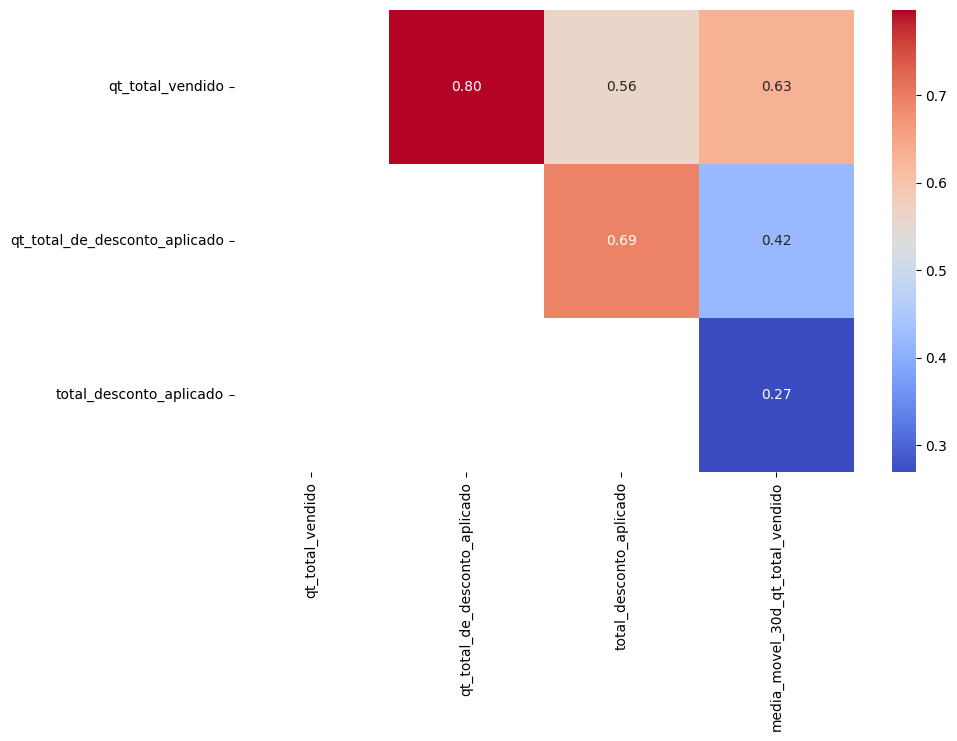

In [103]:
# Exibição da matriz de correlações lineares, em formato de gráfico de calor
plt.figure(figsize = (10, 6))
mask = np.tril(np.ones_like(matriz_cor, dtype = bool)) # para ocultar valores no triângulo abaixo da diagonal
sns.heatmap(matriz_cor, annot = True, fmt = '.2f', cmap = 'coolwarm', mask = mask)
plt.show()

In [104]:
df_vendas_agg.head()

,dt_venda,key_loja,cod_produto,qt_total_vendido,qt_total_de_desconto_aplicado,total_desconto_aplicado,media_movel_30d_qt_total_vendido
0,2024-01-05,1,1428,2,2,96.00,2.000000
1,2024-01-08,1,1428,1,1,48.00,1.500000
2,2024-01-15,1,1428,2,2,277.92,1.666667
3,2024-01-16,1,1428,1,1,69.48,1.500000
4,2024-01-17,1,1428,1,1,48.00,1.400000


In [105]:
X = df_vendas_agg.drop(columns = ['dt_venda', 'key_loja', 'cod_produto'])
y = df_vendas_agg['qt_total_vendido']

In [106]:
valores_0 = df_vendas_agg.query('qt_total_vendido == 0').qt_total_vendido.count()
total_base = df_vendas_agg['qt_total_vendido'].count()

print(f'Total e linhas com valor 0: {valores_0}')
print(f'Tottal de linhas na base: {total_base}')
print(f'Precentual de 0 na base: {round((valores_0/total_base)*100,2)}%')

Total e linhas com valor 0: 0
Tottal de linhas na base: 56689
Precentual de 0 na base: 0.0%


In [107]:
X_sample = X
y_sample = y

In [108]:
np.random.seed(123)
indices = np.random.choice(X.index, size = 1000, replace = False)
X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

In [109]:
pre_processamento = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

In [110]:
# Lista de algoritmos e hiperparâmetros testados (altere os valores conforme a necessidade)
modelos = {
    'REGRESSÃO LINEAR': (LinearRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE REGRESSÃO': (DecisionTreeRegressor(), {
        'criterion': ['squared_error', 'absolute_error'],
        'min_samples_leaf': np.arange(20, 101),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestRegressor(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['squared_error', 'absolute_error'],
        'min_samples_leaf': np.arange(20, 101),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostRegressor(loss = 'square'), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingRegressor(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(20, 101)
    }),
    'XGBOOST': (XGBRegressor(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMRegressor(verbose = -1, importance_type = 'gain', n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(20, 101)
    })
}

In [111]:
X_transformed = pre_processamento.fit_transform(X)
X_sample_transformed = X_transformed[X_sample.index]

In [112]:
melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

In [113]:
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [114]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error', 'r2': 'r2'}

  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_neg_root_mean_squared_error']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_neg_root_mean_squared_error'])

  # Resultados
  print(f'--- {nome} ---')
  print("Média de RMSE: " + str(-round(np.mean(nested_scores['test_neg_root_mean_squared_error']), 3)))
  print("D.P. de RMSE: " + str(round(np.std(nested_scores['test_neg_root_mean_squared_error']), 3)))
  print("Média de MAE: " + str(-round(np.mean(nested_scores['test_neg_mean_absolute_error']), 3)))
  print("D.P. de MAE: " + str(round(np.std(nested_scores['test_neg_mean_absolute_error']), 3)))
  print("Média de MAPE: " + str(-round(np.mean(nested_scores['test_neg_mean_absolute_percentage_error']), 3)))
  print("D.P. de MAPE: " + str(round(np.std(nested_scores['test_neg_mean_absolute_percentage_error']), 3)))
  print("Média de R^2: " + str(round(np.mean(nested_scores['test_r2']), 3)))
  print("D.P. de R^2: " + str(round(np.std(nested_scores['test_r2']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- REGRESSÃO LINEAR ---
Média de RMSE: 0.845
D.P. de RMSE: 0.087
Média de MAE: 0.424
D.P. de MAE: 0.03
Média de MAPE: 0.271
D.P. de MAPE: 0.034
Média de R^2: 0.269
D.P. de R^2: 0.082

--- ÁRVORE DE REGRESSÃO ---
Média de RMSE: 0.839
D.P. de RMSE: 0.084
Média de MAE: 0.431
D.P. de MAE: 0.041
Média de MAPE: 0.263
D.P. de MAPE: 0.03
Média de R^2: 0.276
D.P. de R^2: 0.093

--- FLORESTA ALEATÓRIA ---
Média de RMSE: 0.829
D.P. de RMSE: 0.083
Média de MAE: 0.423
D.P. de MAE: 0.033
Média de MAPE: 0.259
D.P. de MAPE: 0.026
Média de R^2: 0.294
D.P. de R^2: 0.089

--- ADABOOST ---
Média de RMSE: 0.843
D.P. de RMSE: 0.081
Média de MAE: 0.482
D.P. de MAE: 0.035
Média de MAPE: 0.316
D.P. de MAPE: 0.029
Média de R^2: 0.266
D.P. de R^2: 0.109

--- GRADIENT BOOSTING ---
Média de RMSE: 0.794
D.P. de RMSE: 0.104
Média de MAE: 0.42
D.P. de MAE: 0.042
Média de MAPE: 0.259
D.P. de MAPE: 0.033
Média de R^2: 0.344
D.P. de R^2: 0.141

--- XGBOOST ---
Média de RMSE: 0.78
D.P. de RMSE: 0.107
Média de MAE: 0.403

In [115]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

In [117]:
scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error', 'r2': 'r2'}

In [118]:
modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

Melhores hiperparâmetros para XGBOOST: {'n_estimators': 40, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.26, 'gamma': 0.0}


In [ ]:
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [120]:
importancias = modelo_final.best_estimator_.feature_importances_

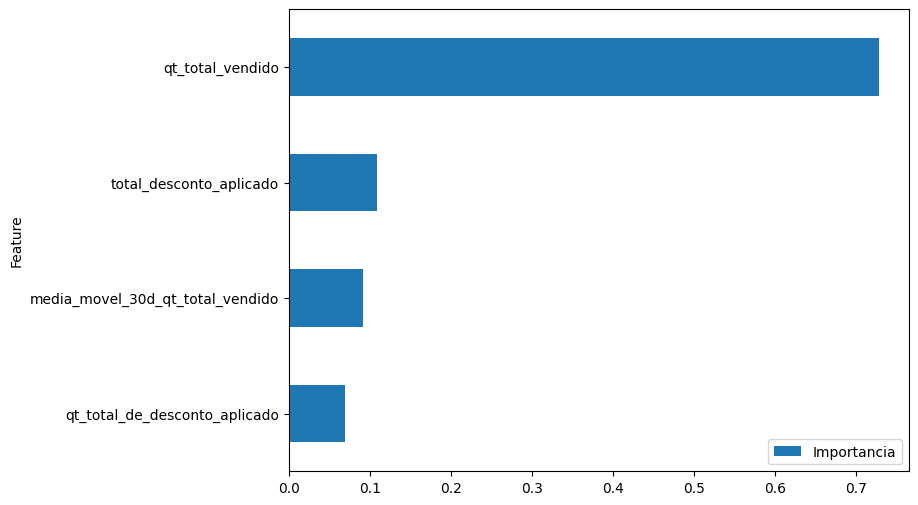

In [121]:
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True).tail(20)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [122]:
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP.")
else:
  explainer = shap.Explainer(modelo_final.best_estimator_)
  valores_shap = explainer(X_sample_transformed)

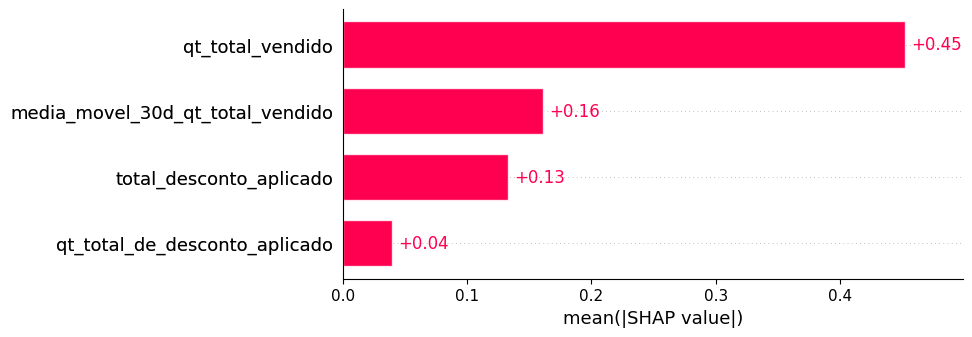

In [123]:
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP.")
else:
  shap.plots.bar(shap.Explanation(values = valores_shap, feature_names = features))

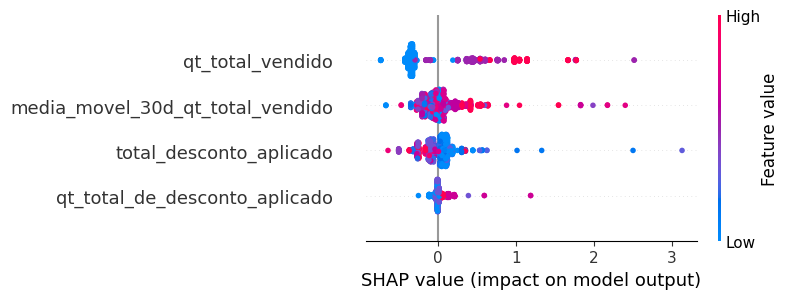

In [124]:
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP")
else:
  shap.summary_plot(shap.Explanation(values = valores_shap, feature_names = features))

In [125]:
y_pred = modelo_final.best_estimator_.predict(X_transformed)

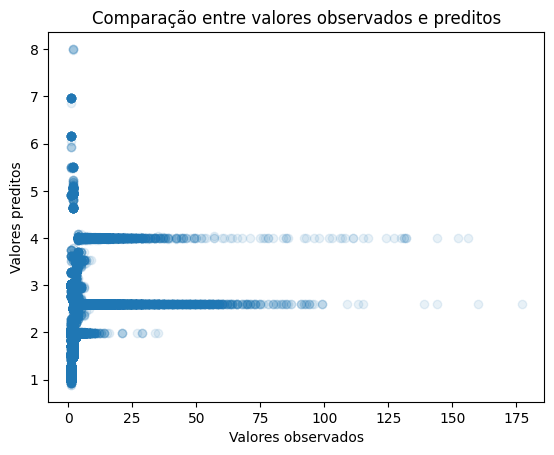

In [126]:
plt.scatter(y, y_pred, alpha = 0.1)
plt.title('Comparação entre valores observados e preditos')
plt.xlabel('Valores observados')
plt.ylabel('Valores preditos')
plt.show()

In [128]:
df_vendas_agg['pred'] = y_pred

In [129]:
df_vendas_agg

,dt_venda,key_loja,cod_produto,qt_total_vendido,qt_total_de_desconto_aplicado,total_desconto_aplicado,media_movel_30d_qt_total_vendido,pred
0,2024-01-05,1,1428,2,2,96.00,2.000000,1.476283
1,2024-01-08,1,1428,1,1,48.00,1.500000,1.666422
2,2024-01-15,1,1428,2,2,277.92,1.666667,1.684230
3,2024-01-16,1,1428,1,1,69.48,1.500000,0.999975
4,2024-01-17,1,1428,1,1,48.00,1.400000,1.000240
...,...,...,...,...,...,...,...,...
101,2024-09-16,8,84206,2,0,0.00,1.285714,2.181823
102,2024-09-18,8,84206,1,0,0.00,1.250000,1.917089
103,2024-09-24,8,84206,1,1,42.00,1.285714,2.985417
104,2024-09-25,8,84206,5,5,311.13,1.750000,2.370216


In [146]:
test_vendas = df_vendas_agg.copy()
test_vendas = test_vendas[(test_vendas['key_loja']==1) & (test_vendas['cod_produto']==1428)]
ultima_data_compras = test_vendas.groupby(['key_loja', 'cod_produto'])['dt_venda'].max().reset_index()

ultima_data_compras = ultima_data_compras.merge(df_vendas_agg, on=['key_loja', 'cod_produto','dt_venda'], how='left')
ultima_data_compras_model = ultima_data_compras.drop(columns = ['key_loja','cod_produto','dt_venda','pred'])

In [147]:
y_pred_teste = modelo_final.best_estimator_.predict(ultima_data_compras_model)
ultima_data_compras['pred'] = y_pred_teste

In [ ]:
ultima_data_compras
#Colocar a data em que teve a ruptura que seria o predito

,key_loja,cod_produto,dt_venda,qt_total_vendido,qt_total_de_desconto_aplicado,total_desconto_aplicado,media_movel_30d_qt_total_vendido,pred
0,1,1428,2024-12-19,1,0,0.0,1.428571,1.000485
